<a href="https://colab.research.google.com/github/leejukyu/Deeplearning/blob/main/VGG_%EC%A1%B0%EB%B3%84%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3조 (강소현,강승훈,공길정,이주경)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

## *** Dataset 구성**

1. batch_size = 100
2. epoch = 10
3. learning_rate = 0.001

In [ ]:
# hyper parameter
num_epochs = 10
batch_size = 100
learning_rate = 0.001
num_classes = 10

In [ ]:
# dataset 구성 전처리 및 argumentation
transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4), # prediect할땐 필요없음
    transforms.RandomHorizontalFlip(),    # prediect할땐 필요없음
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# train dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform_train,
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2)

# test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transform_test)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [ ]:
# 데이터 확인
print(train_dataset.__getitem__(0)[0].size(), train_dataset.__len__())
print(test_dataset.__getitem__(0)[0].size(), test_dataset.__len__())

torch.Size([3, 32, 32]) 50000
torch.Size([3, 32, 32]) 10000


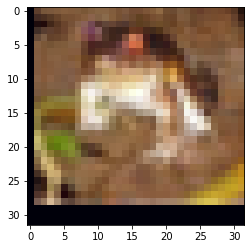

In [ ]:
for data in train_dataset:
    img, label = data
    plt.imshow(torchvision.utils.make_grid(img, nrow=2, normalize=True).permute(1, 2, 0))
    plt.show()
    break

## *** Conv 설정**

1. Convolution 3x3 size, padding = 1 설정
2. batch normalization, Relu 추가

In [ ]:
# Convolution 2번
def conv_2(input_dim, output_dim):
    model = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),

        nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),
        nn.MaxPool2d(2,2)
    )
    return model

# Convolution 4번
def conv_4(input_dim, output_dim):
    model = nn.Sequential(
        nn.Conv2d(input_dim, output_dim,kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),

        nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),

        nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),

        nn.Conv2d(output_dim, output_dim,kernel_size=3, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(True),
        nn.MaxPool2d(2,2)
    )
    return model

1. 마지막 FC layer FC -10
2. FC마다 dropout (p = 0.2) 추가 (마지막 FC 제외)

In [ ]:
class VGG_E(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG_E, self).__init__()
        self.feature = nn.Sequential(
            # 32 * 32
            conv_2(3, base_dim), # 16 * 16
            conv_2(base_dim, 2*base_dim), # 8 * 8
            conv_4(2*base_dim, 4*base_dim), # 4 * 4
            conv_4(4*base_dim, 8*base_dim), # 2 * 2
            conv_4(8*base_dim, 8*base_dim), # 1 * 1         
        )
        
        # FC layer
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 1 * 1, 1000),  # FC layer - 1000
            nn.ReLU(True), 
            nn.Dropout(0.2),                                                    

            nn.Linear(1000, 500), # FC layer - 500
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(500, num_classes), # FC layer - 10
        )

    def forward(self, x):
        out = self.feature(x)
        out = out.view(batch_size, -1)                             
        out = self.fc_layer(out)
        return out
    

## *** Cross Entropy loss / Adam optimization**

In [ ]:
# GPU에서 수행
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# conv3 = 64
model = VGG_E(base_dim = 64)
model = model.to(device)

# learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in model.named_children():
    print(i)

('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

## *** Train**

In [ ]:
# num_epochs = 10
num_train_batches = int(len(train_dataset)/batch_size) # 500
iter = []
loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        x,y = data[0].to(device), data[1].to(device)
        
        # 매개변수 변화도 0
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step() 

        running_loss += loss.item() # 학습 중 손실값
        if i % 100 == 99:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            iter.append(i)
            loss_arr.append(running_loss / 100)
            running_loss = 0.0
    # print(f"Loss : {running_loss / num_train_batches}")
print("Finish Train")

[1,   100] loss: 0.282
[1,   200] loss: 0.275
[1,   300] loss: 0.280
[1,   400] loss: 0.289
[1,   500] loss: 0.277
[2,   100] loss: 0.252
[2,   200] loss: 0.267
[2,   300] loss: 0.266
[2,   400] loss: 0.256
[2,   500] loss: 0.261
[3,   100] loss: 0.269
[3,   200] loss: 0.253
[3,   300] loss: 0.246
[3,   400] loss: 0.242
[3,   500] loss: 0.238
[4,   100] loss: 0.235
[4,   200] loss: 0.241
[4,   300] loss: 0.255
[4,   400] loss: 0.232
[4,   500] loss: 0.243
[5,   100] loss: 0.221
[5,   200] loss: 0.216
[5,   300] loss: 0.232
[5,   400] loss: 0.262
[5,   500] loss: 0.249
[6,   100] loss: 0.219
[6,   200] loss: 0.247
[6,   300] loss: 0.231
[6,   400] loss: 0.244
[6,   500] loss: 0.236
[7,   100] loss: 0.196
[7,   200] loss: 0.223
[7,   300] loss: 0.207
[7,   400] loss: 0.231
[7,   500] loss: 0.243
[8,   100] loss: 0.198
[8,   200] loss: 0.209
[8,   300] loss: 0.214
[8,   400] loss: 0.210
[8,   500] loss: 0.214
[9,   100] loss: 0.196
[9,   200] loss: 0.214
[9,   300] loss: 0.196
[9,   400] 

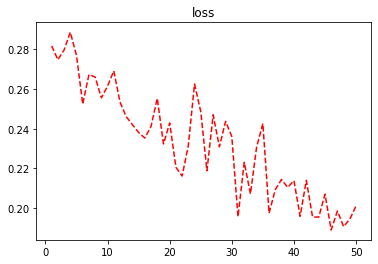

In [ ]:
# loss값 그래프
plt.plot(range(1,len(iter)+1), loss_arr, 'r--')
plt.title("loss")
plt.show()

## *** Test**

In [ ]:
correct = 0
total = 0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for data in test_loader:
        x,y = data[0].to(device), data[1].to(device)

        output = model.forward(x)
        _, predicted = torch.max(output,1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        # squeeze함수 차원이 1인 차원을 제거
        c = (predicted == y).squeeze()
        for i in range(4):
            y_ = y[i]
            class_correct[y_] += c[i].item()
            class_total[y_] += 1
    print("정확도: {}%".format(100*correct/total))
    print("-------------------------------------")
    
for i in range(10):
    print('class별 정확도 / %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

정확도: 88.66%
-------------------------------------
class별 정확도 / plane : 97 %
class별 정확도 /   car : 100 %
class별 정확도 /  bird : 84 %
class별 정확도 /   cat : 76 %
class별 정확도 /  deer : 81 %
class별 정확도 /   dog : 84 %
class별 정확도 /  frog : 94 %
class별 정확도 / horse : 90 %
class별 정확도 /  ship : 97 %
class별 정확도 / truck : 100 %
